In [49]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download=True
)

In [50]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [51]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [52]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [53]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [54]:
train_data.targets.shape

torch.Size([60000])

In [55]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [56]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
    'test': DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1)
}


In [57]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [58]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders['train'].dataset)} ({100. * batch_idx / len(loaders['train']):.0}%)]\t{loss.item():.6f}')
            
def test():
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    
    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({100. * correct / len(loaders['test'].dataset):.0f}%)\n')

In [59]:
import time
start_time = time.time()
for epoch in range(1, 11):
    train(epoch)
    test()
end_time = time.time()
print(f'Total time: {end_time - start_time:.2f} seconds')

/var/folders/lp/h9ryjfsj4wx5rsdk3mrqk3nh0000gn/T/ipykernel_17255/2541791753.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0e+00%)]	2.304632
Train Epoch: 1 [2000/60000 (3e+00%)]	2.244067
Train Epoch: 1 [4000/60000 (7e+00%)]	2.123962
Train Epoch: 1 [6000/60000 (1e+01%)]	1.973491
Train Epoch: 1 [8000/60000 (1e+01%)]	1.954025
Train Epoch: 1 [10000/60000 (2e+01%)]	1.921297
Train Epoch: 1 [12000/60000 (2e+01%)]	1.885449
Train Epoch: 1 [14000/60000 (2e+01%)]	1.793692
Train Epoch: 1 [16000/60000 (3e+01%)]	1.790241
Train Epoch: 1 [18000/60000 (3e+01%)]	1.752920
Train Epoch: 1 [20000/60000 (3e+01%)]	1.799486
Train Epoch: 1 [22000/60000 (4e+01%)]	1.719705
Train Epoch: 1 [24000/60000 (4e+01%)]	1.686608
Train Epoch: 1 [26000/60000 (4e+01%)]	1.680730
Train Epoch: 1 [28000/60000 (5e+01%)]	1.682755
Train Epoch: 1 [30000/60000 (5e+01%)]	1.653360
Train Epoch: 1 [32000/60000 (5e+01%)]	1.636886
Train Epoch: 1 [34000/60000 (6e+01%)]	1.685706
Train Epoch: 1 [36000/60000 (6e+01%)]	1.585325
Train Epoch: 1 [38000/60000 (6e+01%)]	1.700668
Train Epoch: 1 [40000/60000 (7e+01%)]	1.640928
Train Epoch: 1 [42000

In [60]:
device

device(type='cpu')

Matplotlib is building the font cache; this may take a moment.
/var/folders/lp/h9ryjfsj4wx5rsdk3mrqk3nh0000gn/T/ipykernel_17255/2541791753.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 7


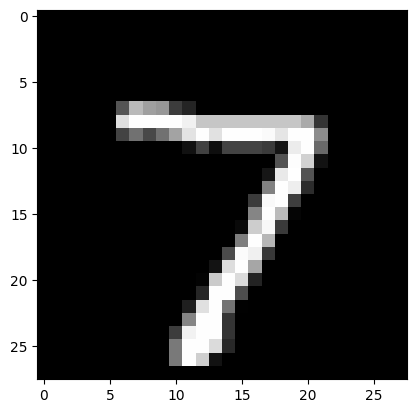

In [61]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[0]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()